# Model Training for Dataset A

### Importing libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import gensim.downloader as gensim_api
import numpy as np
import json

# Load word embeddings
word2vec = gensim_api.load("word2vec-google-news-300")
glove = gensim_api.load("glove-wiki-gigaword-300")
fasttext = gensim_api.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 376.1/376.1MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


### Loading Dataset (Json)

In [3]:
with open('../data/ATE_Train.json','r') as f:
    train_json = json.load(f)
with open('../data/ATE_Val.json','r') as f:
    val_json = json.load(f)
with open('../data/ATE_Test.json','r') as f:
    test_json = json.load(f)

In [4]:
def get_embeddings(text, embeddings):
    words = text.split()
    embeddings_list = [embeddings[word] if word in embeddings else np.zeros(embeddings.vector_size) for word in words]
    return torch.tensor(embeddings_list, dtype=torch.float32)

# Convert JSON dataset to numerical format
def get_dataset(word_embedding, json_file, label_mapping):
    numerical_dataset = []
    for key, example in json_file.items():
        text_embeddings = get_embeddings(example["text"], word_embedding)
        label_sequence = torch.tensor([label_mapping[label] for label in example["labels"]], dtype=torch.float32)
        numerical_dataset.append((text_embeddings, label_sequence))
    return numerical_dataset

In [5]:
label_mapping = {"B": 0, "I": 1, "O": 2}
word2vec_train_embeddings = get_dataset(word_embedding=word2vec, json_file=train_json, label_mapping=label_mapping)
word2vec_val_embeddings = get_dataset(word_embedding=word2vec, json_file=val_json, label_mapping=label_mapping)
word2vec_test_embeddings = get_dataset(word_embedding=word2vec, json_file=test_json, label_mapping=label_mapping)

glove_train_embeddings = get_dataset(word_embedding=glove, json_file=train_json, label_mapping=label_mapping)
glove_val_embeddings = get_dataset(word_embedding=glove, json_file=val_json, label_mapping=label_mapping)
glove_test_embeddings = get_dataset(word_embedding=glove, json_file=test_json, label_mapping=label_mapping)

fasttext_train_embeddings = get_dataset(word_embedding=fasttext, json_file=train_json, label_mapping=label_mapping)
fasttext_val_embeddings = get_dataset(word_embedding=fasttext, json_file=val_json, label_mapping=label_mapping)
fasttext_test_embeddings = get_dataset(word_embedding=fasttext, json_file=test_json, label_mapping=label_mapping)

C:\Users\aksha\AppData\Local\Temp\ipykernel_13108\2760256805.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(embeddings_list, dtype=torch.float32)


### Models (RNN, LSTM, GRU)

In [6]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, (hn, cn) = self.lstm(x, (h0, c0))  # Forward propagate LSTM
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out


### Train and loss functions

In [7]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import warnings

def train_model(model, train_data, val_data, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_data:
            # print(inputs.shape)
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(0)
            
            outputs = model(inputs)
            # print(outputs.shape)
            # print(labels.dtype)
            # print(type(outputs), type(inputs), type(labels))
            
            outputs = outputs.to(torch.float)
            labels = torch.tensor(labels, dtype=torch.long)
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs.view(-1, output_size), labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        predictions = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in val_data:
                # Add a batch dimension to the inputs
                inputs = inputs.unsqueeze(0)
                outputs = model(inputs)
                labels = torch.tensor(labels, dtype=torch.long)
                val_loss += criterion(outputs.view(-1, output_size), labels)
                _, predicted = torch.max(outputs, 2)
                predictions.extend(predicted.view(-1).cpu().numpy())
                true_labels.extend(labels.view(-1).cpu().numpy())

        val_loss /= len(val_data)
        train_losses.append(loss.item())
        val_losses.append(val_loss)

        # Calculate F1 scores
        train_f1 = f1_score(true_labels, predictions, average='macro')
        val_f1 = f1_score(true_labels, predictions, average='macro')
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}, Train Loss: {loss.item():.4f}, Train F1 Score: {train_f1:.4f}.....')

    # Function to plot loss
    def plot_loss(train_losses, val_losses):
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    # Function to plot F1 score
    def plot_f1_score(train_f1_scores, val_f1_scores):
        plt.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, label='Training F1 Score')
        plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.title('Training and Validation F1 Score')
        plt.legend()
        plt.show()
    plot_loss(train_losses, val_losses)
    plot_f1_score(train_f1_scores, val_f1_scores)


### Testing 

In [8]:
def calculate_f1_score(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(0)
            outputs = model(inputs)
            labels = torch.tensor(labels, dtype=torch.long)
            _, predicted = torch.max(outputs, 2)
            predictions.extend(predicted.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
    test_f1 = f1_score(true_labels, predictions, average='macro')
    return test_f1

In [9]:
import warnings
warnings.filterwarnings('ignore')

### Model Training and Evaluation using Word2Vec Embeddings ###


Training lstm model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1713, Validation F1 Score: 0.7400, Train Loss: 0.0918, Train F1 Score: 0.7400.....
Epoch 2/10, Validation Loss: 0.1518, Validation F1 Score: 0.7730, Train Loss: 0.1029, Train F1 Score: 0.7730.....
Epoch 3/10, Validation Loss: 0.1479, Validation F1 Score: 0.7763, Train Loss: 0.1117, Train F1 Score: 0.7763.....
Epoch 4/10, Validation Loss: 0.1480, Validation F1 Score: 0.7980, Train Loss: 0.0792, Train F1 Score: 0.7980.....
Epoch 5/10, Validation Loss: 0.1542, Validation F1 Score: 0.7915, Train Loss: 0.0518, Train F1 Score: 0.7915.....
Epoch 6/10, Validation Loss: 0.1628, Validation F1 Score: 0.7832, Train Loss: 0.0242, Train F1 Score: 0.7832.....
Epoch 7/10, Validation Loss: 0.1712, Validation F1 Score: 0.7991, Train Loss: 0.0022, Train F1 Score: 0.7991.....
Epoch 8/10, Validation Loss: 0.1776, Validation F1 Score: 0.8018, Train Loss: 0.0021, Train F1 Score: 0.8018.....
Epoch 9/10, Validation Loss: 0.1947, Vali

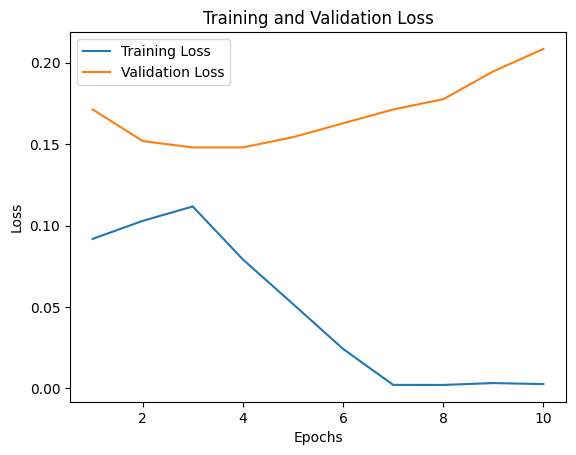

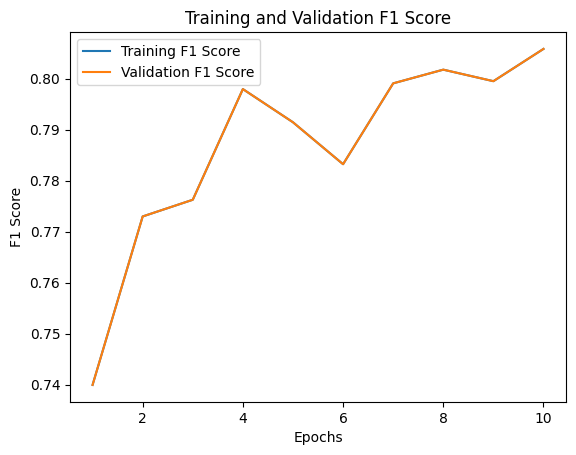

lstm Model Testing using word2vec embeddings (Test F1 Score): 0.7651

Training gru model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1580, Validation F1 Score: 0.7579, Train Loss: 0.0629, Train F1 Score: 0.7579.....
Epoch 2/10, Validation Loss: 0.1463, Validation F1 Score: 0.7773, Train Loss: 0.0499, Train F1 Score: 0.7773.....
Epoch 3/10, Validation Loss: 0.1450, Validation F1 Score: 0.7952, Train Loss: 0.0538, Train F1 Score: 0.7952.....
Epoch 4/10, Validation Loss: 0.1473, Validation F1 Score: 0.8057, Train Loss: 0.0482, Train F1 Score: 0.8057.....
Epoch 5/10, Validation Loss: 0.1562, Validation F1 Score: 0.8072, Train Loss: 0.0295, Train F1 Score: 0.8072.....
Epoch 6/10, Validation Loss: 0.1656, Validation F1 Score: 0.8031, Train Loss: 0.0269, Train F1 Score: 0.8031.....
Epoch 7/10, Validation Loss: 0.1785, Validation F1 Score: 0.7897, Train Loss: 0.0192, Train F1 Score: 0.7897.....
Epoch 8/10, Validation Loss: 0.1925, Validation F1 Score: 0.7988, Train Loss: 0.0243, T

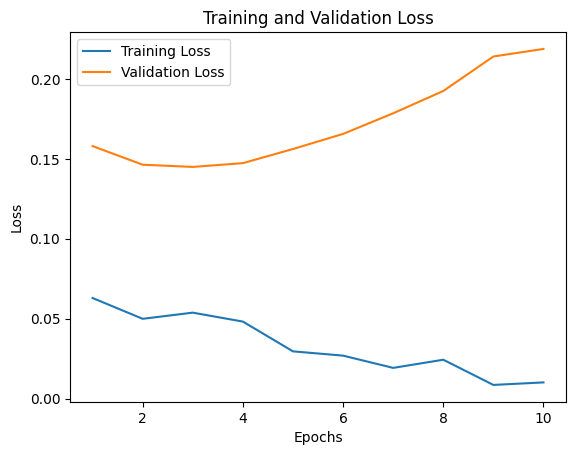

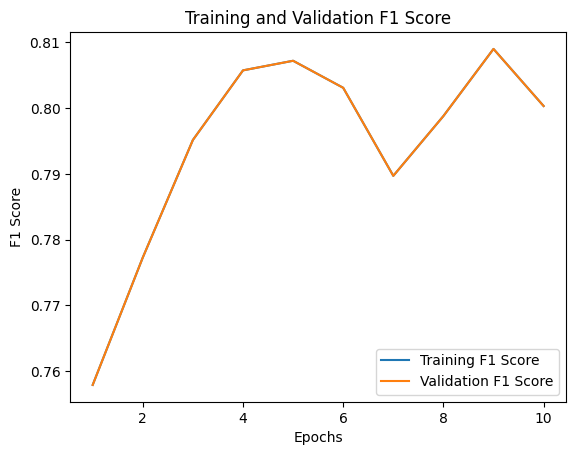

gru Model Testing using word2vec embeddings (Test F1 Score): 0.7681

Training vanilla_rnn model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1866, Validation F1 Score: 0.7404, Train Loss: 0.1014, Train F1 Score: 0.7404.....
Epoch 2/10, Validation Loss: 0.1717, Validation F1 Score: 0.7287, Train Loss: 0.1024, Train F1 Score: 0.7287.....
Epoch 3/10, Validation Loss: 0.1733, Validation F1 Score: 0.7424, Train Loss: 0.1330, Train F1 Score: 0.7424.....
Epoch 4/10, Validation Loss: 0.1735, Validation F1 Score: 0.7492, Train Loss: 0.1287, Train F1 Score: 0.7492.....
Epoch 5/10, Validation Loss: 0.1846, Validation F1 Score: 0.7422, Train Loss: 0.1134, Train F1 Score: 0.7422.....
Epoch 6/10, Validation Loss: 0.2081, Validation F1 Score: 0.7479, Train Loss: 0.1409, Train F1 Score: 0.7479.....
Epoch 7/10, Validation Loss: 0.2081, Validation F1 Score: 0.7455, Train Loss: 0.0868, Train F1 Score: 0.7455.....
Epoch 8/10, Validation Loss: 0.2078, Validation F1 Score: 0.7478, Train Loss: 0.

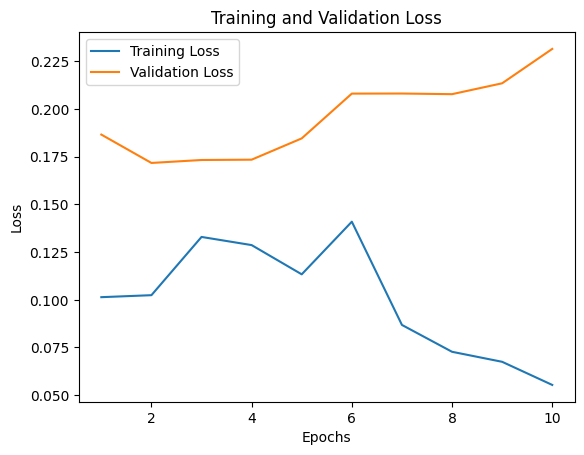

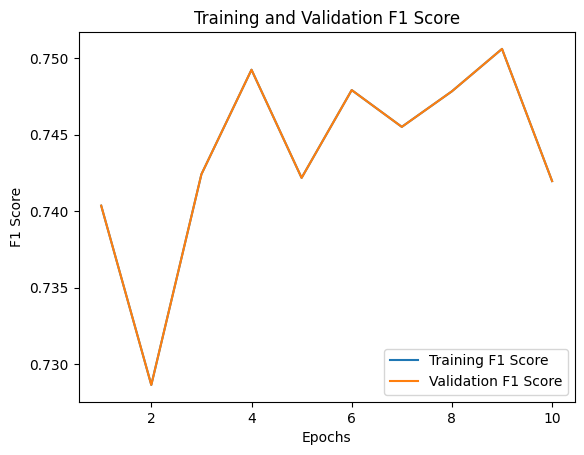

vanilla_rnn Model Testing using word2vec embeddings (Test F1 Score): 0.7236


In [10]:
models = {
    'lstm': LSTMModel,
    'gru': GRUModel,
    'vanilla_rnn': VanillaRNN
}

# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10

for model_name, model_class in models.items():
    print(f'\nTraining {model_name} model with word2vec embeddings:')
    model = model_class(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, word2vec_train_embeddings, word2vec_val_embeddings, criterion, optimizer, num_epochs)
    
    # Calculate and print the test F1 score
    test_f1_score = calculate_f1_score(model, word2vec_test_embeddings)
    print(f'{model_name} Model Testing using word2vec embeddings (Test F1 Score): {test_f1_score:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), f'{model_name}_word2vec_model.pth')

### Model Training and Evaluation using Glove Embeddings ###


Training vanilla_rnn model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.2037, Validation F1 Score: 0.7090, Train Loss: 0.1635, Train F1 Score: 0.7090.....
Epoch 2/10, Validation Loss: 0.1947, Validation F1 Score: 0.7230, Train Loss: 0.1443, Train F1 Score: 0.7230.....
Epoch 3/10, Validation Loss: 0.1946, Validation F1 Score: 0.7369, Train Loss: 0.1119, Train F1 Score: 0.7369.....
Epoch 4/10, Validation Loss: 0.1989, Validation F1 Score: 0.7343, Train Loss: 0.0881, Train F1 Score: 0.7343.....
Epoch 5/10, Validation Loss: 0.2102, Validation F1 Score: 0.7118, Train Loss: 0.0781, Train F1 Score: 0.7118.....
Epoch 6/10, Validation Loss: 0.2245, Validation F1 Score: 0.7150, Train Loss: 0.0634, Train F1 Score: 0.7150.....
Epoch 7/10, Validation Loss: 0.2378, Validation F1 Score: 0.7113, Train Loss: 0.0495, Train F1 Score: 0.7113.....
Epoch 8/10, Validation Loss: 0.2600, Validation F1 Score: 0.7056, Train Loss: 0.0315, Train F1 Score: 0.7056.....
Epoch 9/10, Validation Loss: 0.251

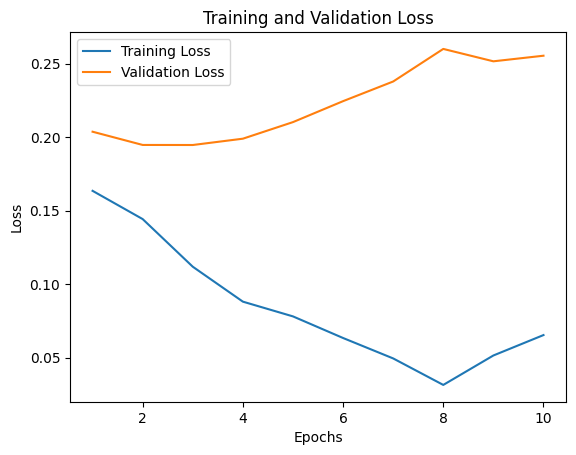

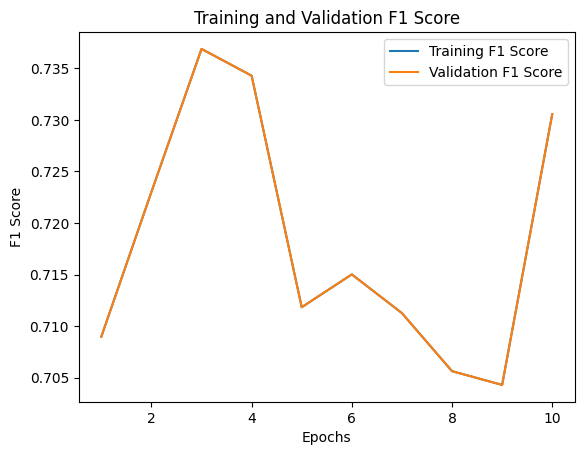

vanilla_rnn Model Testing using word2vec embeddings (Test F1 Score): 0.6844

Training lstm model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1995, Validation F1 Score: 0.7073, Train Loss: 0.1270, Train F1 Score: 0.7073.....
Epoch 2/10, Validation Loss: 0.1763, Validation F1 Score: 0.7383, Train Loss: 0.1148, Train F1 Score: 0.7383.....
Epoch 3/10, Validation Loss: 0.1711, Validation F1 Score: 0.7565, Train Loss: 0.0892, Train F1 Score: 0.7565.....
Epoch 4/10, Validation Loss: 0.1801, Validation F1 Score: 0.7432, Train Loss: 0.0614, Train F1 Score: 0.7432.....
Epoch 5/10, Validation Loss: 0.1906, Validation F1 Score: 0.7564, Train Loss: 0.0499, Train F1 Score: 0.7564.....
Epoch 6/10, Validation Loss: 0.2130, Validation F1 Score: 0.7543, Train Loss: 0.0344, Train F1 Score: 0.7543.....
Epoch 7/10, Validation Loss: 0.2170, Validation F1 Score: 0.7617, Train Loss: 0.0665, Train F1 Score: 0.7617.....
Epoch 8/10, Validation Loss: 0.2111, Validation F1 Score: 0.7657, Train Loss: 0

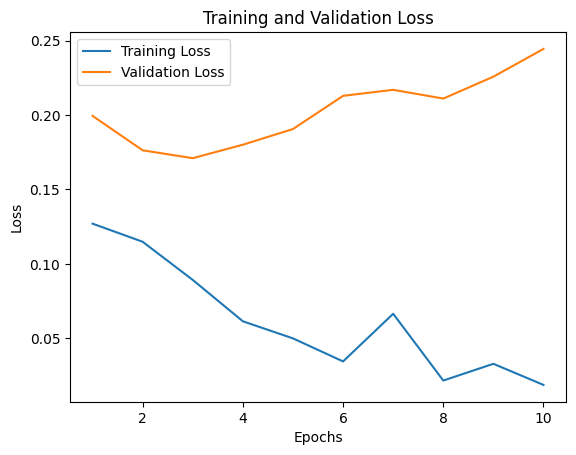

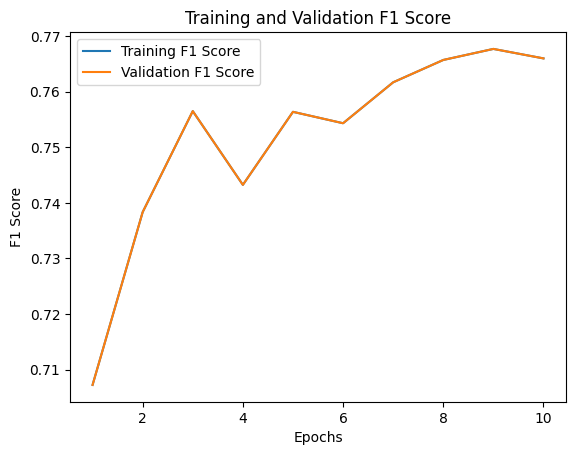

lstm Model Testing using word2vec embeddings (Test F1 Score): 0.7034

Training gru model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1939, Validation F1 Score: 0.7152, Train Loss: 0.1249, Train F1 Score: 0.7152.....
Epoch 2/10, Validation Loss: 0.1760, Validation F1 Score: 0.7642, Train Loss: 0.0957, Train F1 Score: 0.7642.....
Epoch 3/10, Validation Loss: 0.1757, Validation F1 Score: 0.7720, Train Loss: 0.0678, Train F1 Score: 0.7720.....
Epoch 4/10, Validation Loss: 0.1908, Validation F1 Score: 0.7635, Train Loss: 0.0541, Train F1 Score: 0.7635.....
Epoch 5/10, Validation Loss: 0.2099, Validation F1 Score: 0.7481, Train Loss: 0.0535, Train F1 Score: 0.7481.....
Epoch 6/10, Validation Loss: 0.2254, Validation F1 Score: 0.7651, Train Loss: 0.0374, Train F1 Score: 0.7651.....
Epoch 7/10, Validation Loss: 0.2517, Validation F1 Score: 0.7540, Train Loss: 0.0318, Train F1 Score: 0.7540.....
Epoch 8/10, Validation Loss: 0.2589, Validation F1 Score: 0.7511, Train Loss: 0.0710, T

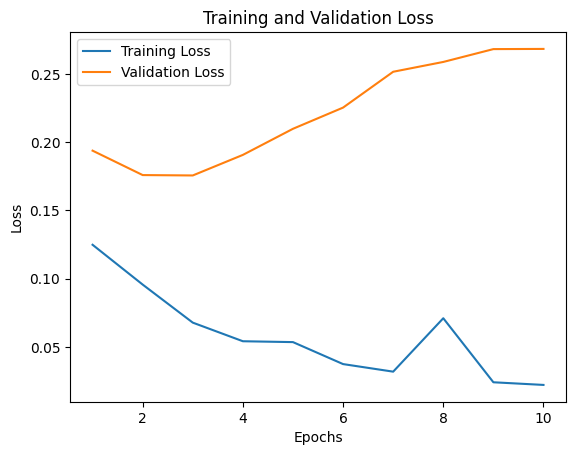

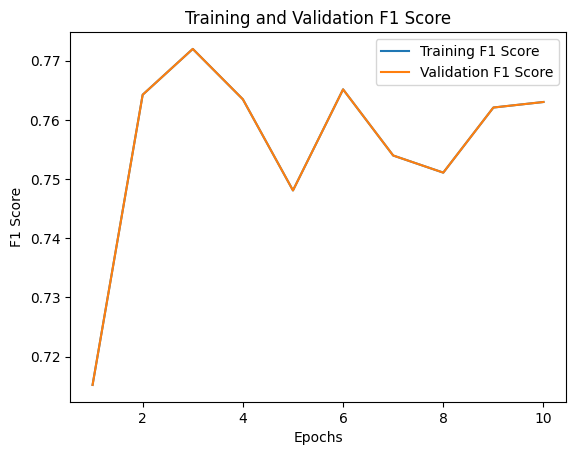

gru Model Testing using word2vec embeddings (Test F1 Score): 0.7374


In [11]:
models = {
    'vanilla_rnn': VanillaRNN,
    'lstm': LSTMModel,
    'gru': GRUModel
}

# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10

for model_name, model_class in models.items():
    print(f'\nTraining {model_name} model with word2vec embeddings:')
    model = model_class(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, glove_train_embeddings, glove_val_embeddings, criterion, optimizer, num_epochs)
    
    # Calculate and print the test F1 score
    test_f1_score = calculate_f1_score(model, glove_test_embeddings)
    print(f'{model_name} Model Testing using word2vec embeddings (Test F1 Score): {test_f1_score:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), f'{model_name}_word2vec_model.pth')

### Model Training and Evaluation using fasttesxt Embeddings ###


Training vanilla_rnn model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1666, Validation F1 Score: 0.7507, Train Loss: 0.1016, Train F1 Score: 0.7507.....
Epoch 2/10, Validation Loss: 0.1563, Validation F1 Score: 0.7645, Train Loss: 0.0930, Train F1 Score: 0.7645.....
Epoch 3/10, Validation Loss: 0.1564, Validation F1 Score: 0.7655, Train Loss: 0.0947, Train F1 Score: 0.7655.....
Epoch 4/10, Validation Loss: 0.1569, Validation F1 Score: 0.7625, Train Loss: 0.1068, Train F1 Score: 0.7625.....
Epoch 5/10, Validation Loss: 0.1566, Validation F1 Score: 0.7618, Train Loss: 0.1172, Train F1 Score: 0.7618.....
Epoch 6/10, Validation Loss: 0.1577, Validation F1 Score: 0.7558, Train Loss: 0.1293, Train F1 Score: 0.7558.....
Epoch 7/10, Validation Loss: 0.1715, Validation F1 Score: 0.7301, Train Loss: 0.1366, Train F1 Score: 0.7301.....
Epoch 8/10, Validation Loss: 0.1820, Validation F1 Score: 0.7363, Train Loss: 0.1564, Train F1 Score: 0.7363.....
Epoch 9/10, Validation Loss: 0.180

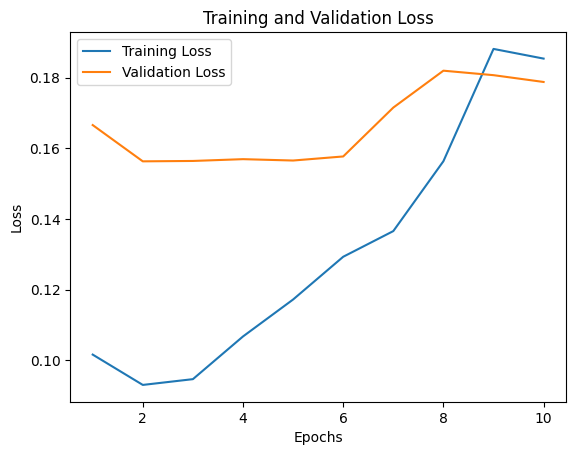

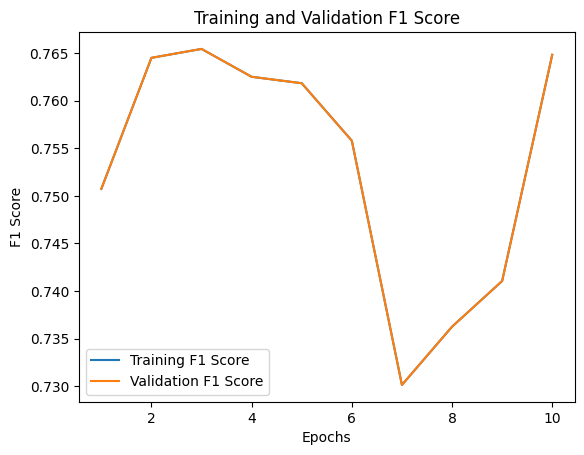

vanilla_rnn Model Testing using word2vec embeddings (Test F1 Score): 0.7562

Training lstm model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1773, Validation F1 Score: 0.7187, Train Loss: 0.0972, Train F1 Score: 0.7187.....
Epoch 2/10, Validation Loss: 0.1589, Validation F1 Score: 0.7537, Train Loss: 0.0898, Train F1 Score: 0.7537.....
Epoch 3/10, Validation Loss: 0.1486, Validation F1 Score: 0.7660, Train Loss: 0.0896, Train F1 Score: 0.7660.....
Epoch 4/10, Validation Loss: 0.1452, Validation F1 Score: 0.7689, Train Loss: 0.0991, Train F1 Score: 0.7689.....
Epoch 5/10, Validation Loss: 0.1456, Validation F1 Score: 0.7687, Train Loss: 0.1128, Train F1 Score: 0.7687.....
Epoch 6/10, Validation Loss: 0.1491, Validation F1 Score: 0.7697, Train Loss: 0.1304, Train F1 Score: 0.7697.....
Epoch 7/10, Validation Loss: 0.1521, Validation F1 Score: 0.7792, Train Loss: 0.1165, Train F1 Score: 0.7792.....
Epoch 8/10, Validation Loss: 0.1543, Validation F1 Score: 0.7820, Train Loss: 0

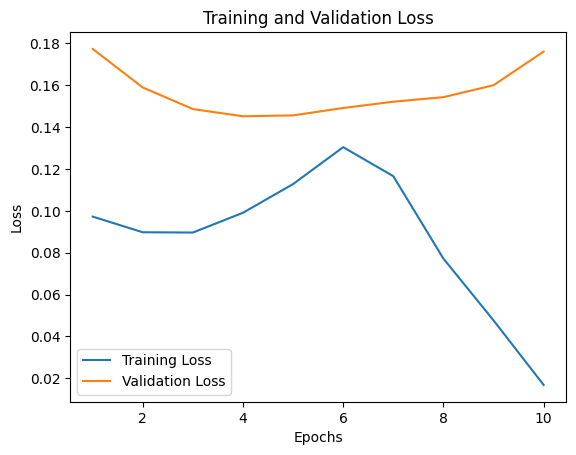

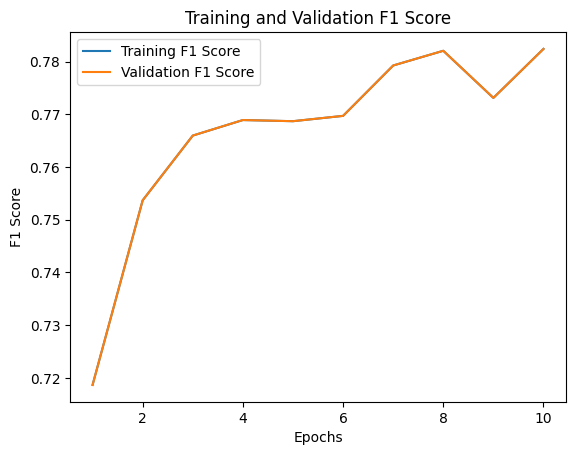

lstm Model Testing using word2vec embeddings (Test F1 Score): 0.7685

Training gru model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1606, Validation F1 Score: 0.7456, Train Loss: 0.0791, Train F1 Score: 0.7456.....
Epoch 2/10, Validation Loss: 0.1483, Validation F1 Score: 0.7793, Train Loss: 0.0814, Train F1 Score: 0.7793.....
Epoch 3/10, Validation Loss: 0.1457, Validation F1 Score: 0.7818, Train Loss: 0.0767, Train F1 Score: 0.7818.....
Epoch 4/10, Validation Loss: 0.1485, Validation F1 Score: 0.7816, Train Loss: 0.0672, Train F1 Score: 0.7816.....
Epoch 5/10, Validation Loss: 0.1536, Validation F1 Score: 0.7847, Train Loss: 0.0561, Train F1 Score: 0.7847.....
Epoch 6/10, Validation Loss: 0.1599, Validation F1 Score: 0.7810, Train Loss: 0.0444, Train F1 Score: 0.7810.....
Epoch 7/10, Validation Loss: 0.1682, Validation F1 Score: 0.7780, Train Loss: 0.0371, Train F1 Score: 0.7780.....
Epoch 8/10, Validation Loss: 0.1799, Validation F1 Score: 0.7694, Train Loss: 0.0586, T

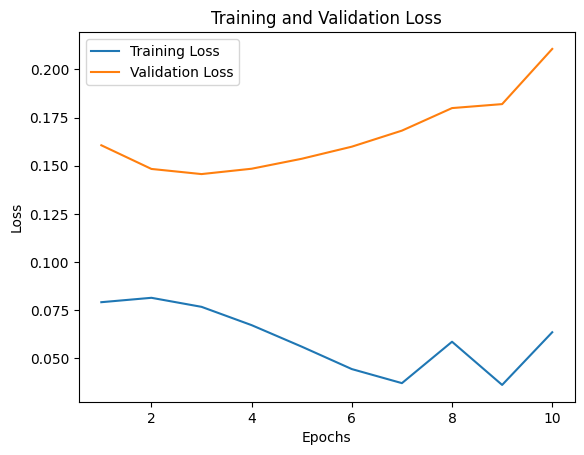

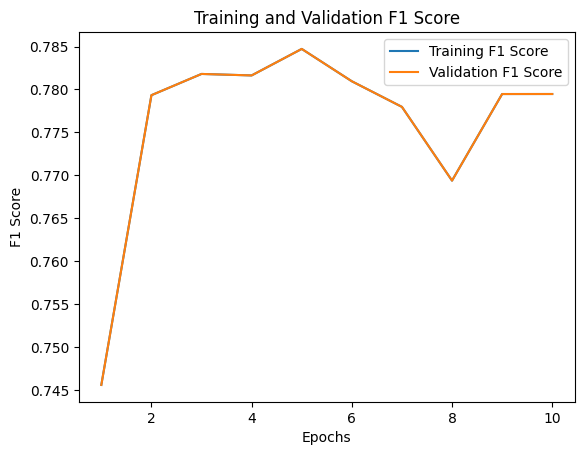

gru Model Testing using word2vec embeddings (Test F1 Score): 0.7542


In [12]:
import torch.nn as nn
import torch.optim as optim

# Models
models = {
    'vanilla_rnn': VanillaRNN,
    'lstm': LSTMModel,
    'gru': GRUModel
}

# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10

for model_name, model_class in models.items():
    print(f'\nTraining {model_name} model with word2vec embeddings:')
    model = model_class(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, fasttext_train_embeddings, fasttext_val_embeddings, criterion, optimizer, num_epochs)
    
    # Calculate and print the test F1 score
    test_f1_score = calculate_f1_score(model, fasttext_test_embeddings)
    print(f'{model_name} Model Testing using word2vec embeddings (Test F1 Score): {test_f1_score:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), f'{model_name}_word2vec_model.pth')


----------------------------------------------------------------------------- EOF --------------------------------------------------------------------------------